# Working with NetCDF files 

One of the most common file formats within environmental science is NetCDF ([Network Common Data Form](https://www.unidata.ucar.edu/software/netcdf/)). 

This format allows for storage of multiple variables, over multiple dimensions (i.e. N-dimensional arrays).   
Files also contain the associated history and variable attributes. 

Example dataset format:  (from http://xarray.pydata.org/en/stable/data-structures.html)

<br>
<img src="../figures/dataset-diagram.png">
<br>


If you're not familiar with NetCDF, and would like to know more, there is a bit more general information at the bottom of this notebook.  

For now, we'll simply focus on how to access and work with these files in python ... 

# NetCDF in python

There are a few different packages that can be used to access data from NetCDF files.  
These include: 

* [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html)
  * Core NetCDF package within python.  
* [iris](https://scitools.org.uk/iris/docs/latest/index.html) 
  * Developed for earth system data. 
  * Data and metadata read into and stored within "cubes". 
* [xarray](http://xarray.pydata.org/en/stable/)
  * A higher-level package, with a pandas-like interface for netCDF. 
  * What we'll focus on here today...


## netCDF4

Contains everything you need to read/modify/create netCDF files. e.g. 

```python
from netCDF4 import Dataset
import numpy as np

openfile = Dataset('../data/cefas_GETM_nwes.nc4')
bathymetry = openfile.variables['bathymetry'][:]
```

Variables are read into NumPy arrays (masked arrays if missing values specified). 

## xarray


* Alternative to plain netCDF4 access from python. 

* Brings the power of pandas to environmental sciences, by providing N-dimensional variants of the core pandas data structures.
  * Worth using for N-dimensional data, even when not reading netCDF files?

| Pandas | xarray  |
|---|---|
| 1-D Series  | DataArray  |
| DataFrame  | Dataset  |

DataArray uses names for each dimension, making it easier to track than by just using axis numbers. 

For example, if you want to average your DataArray (da) over time, it is possible to write `da.mean(dim='time')`  
You don't have to remember the index of the time axis.

Compare:
```python
# xarray style
>>> da.sel(time='2018-01-12').max(dim='ensemble')

# standard numpy style
>>> array[3, :, :].max(axis=2)
```

Without xarray, you need to first check which row refers to `time='2018-01-12'`, and which dimension is relevant for the ensemble. 

In the NumPy example, these choices are also not obvious to anyone reading the code at a later date. 

#### The main advantages of using xarray versus plain netCDF4 are:

* intelligent selection along labelled dimensions (and also indices)
* [groupby operations](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html)
* data alignment across named axes
* IO (netcdf)
  * Attributes/metadata held with the dataset. 
* conversion from and to Pandas.DataFrames

## Xarray as Pandas for N dimensions

In [1]:
# Import everything that we are going to need... but not more
import pandas as pd
import xarray as xr
import numpy as np

In [2]:
pd_s = pd.Series(range(3), index=list('abc'))
print(pd_s)

a    0
b    1
c    2
dtype: int64


In [3]:
#convert 1D series to ND aware DataArray 
da = xr.DataArray(pd_s)
print(da)

<xarray.DataArray (dim_0: 3)>
array([0, 1, 2], dtype=int64)
Coordinates:
  * dim_0    (dim_0) object 'a' 'b' 'c'


In [4]:
#convert 2D DataFrame to ND aware Dataset
df = pd.DataFrame.from_dict({'A': [1, 2, 3], 'B': [4, 5, 6]},                         
                             orient='index', columns=['one', 'two', 'three'])
df

,one,two,three
A,1,2,3
B,4,5,6


In [5]:
ds = xr.Dataset.from_dataframe(df)
ds

<xarray.Dataset>
Dimensions:  (index: 2)
Coordinates:
  * index    (index) object 'A' 'B'
Data variables:
    one      (index) int64 1 4
    two      (index) int64 2 5
    three    (index) int64 3 6

---

# Let's open a netCDF file

Xarray allows you to open both local and remote datasets. 

Remote datasets can be accessed through [OpenDAP](http://xarray.pydata.org/en/stable/io.html#opendap), allowing you to download (and subset) data available online.  
e.g. you can access ocean colour data directly into python (from dataset acccessible online [here](earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap/opendap-servers)):   
```python
remote_data = xr.open_dataset(
      'https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/2020/176/A2020176.L3m_DAY_CHL_chlor_a_9km.nc')

``` 


Here we'll use a file available locally on your machine (find in your data folder): `cefas_GETM_nwes.nc4`

This is output from a 3D ocean model, GETM, from the European NW Shelf. 

### Open our dataset

In [6]:
GETM = xr.open_dataset('../data/cefas_GETM_nwes.nc4')
GETM

<xarray.Dataset>
Dimensions:     (latc: 360, lonc: 396, time: 6, level: 5)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 ... 63.2 63.25 63.3 63.35
  * level       (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc        (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time        (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:0...
Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 ...
Attributes:
    title:                     North West European Shelf 3nm
    history:                   Sun Nov 20 00:54:48 2016: ncks -v time,latc,lo...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

We can extract information on the dimensions, coordinates and attributes of the dataset

In [7]:
# List dimensions
GETM.dims

Frozen({'latc': 360, 'lonc': 396, 'time': 6, 'level': 5})

* latc = latitude
* lonc = longitude
* time = time!
* level = depth surface within the 3D model (terrain-following vertical coordinate). 

In [8]:
# Extract coordinates
print(type(GETM.coords['latc']))
GETM.coords['latc'].shape

<class 'xarray.core.dataarray.DataArray'>


(360,)

In [9]:
# List name of dataset attributes
GETM.attrs.keys()

dict_keys(['title', 'history', 'NCO', 'nco_openmp_thread_number'])

In [10]:
# List variables
#GETM.data_vars
for var in GETM.data_vars: 
   print(var)

bathymetry
h
temp


Note that time is automatically read/stored in datetime format - xarray understands the units and reference time. 

* This makes for easier subsetting or slicing, as you'll find out later... 
 

### Extract variable from dataset

In [11]:
temp = GETM['temp']
print(temp.shape)
temp

# Can also use: 
# GETM.temp

(6, 5, 360, 396)


<xarray.DataArray 'temp' (time: 6, level: 5, latc: 360, lonc: 396)>
[4276800 values with dtype=float32]
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
  * level    (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

Check variable attributes, in the same way we access DataSet attributes

In [12]:
print(temp.attrs)
print( f"Variable { temp.attrs['long_name'] } has units { temp.attrs['units'] }" )

{'units': 'degC', 'long_name': 'temperature', 'valid_range': array([-2., 40.], dtype=float32)}
Variable temperature has units degC


### Accessing data values

Data can be subset using standard indexing methods. 

In [13]:
temp[0, 0, 90, 100]

<xarray.DataArray 'temp' ()>
array(11.532867)
Coordinates:
    latc     float64 49.9
    level    float64 1.0
    lonc     float64 -9.5
    time     datetime64[ns] 1996-02-01T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

Note that the DataArray subset keeps track of the associated coordinates, as well as other attributes. 

Behind the scenes, data values are still stored as NumPy arrays. 

In [14]:
print(type(temp.values))
temp.values[0, 0, 90, 100]

<class 'numpy.ndarray'>


11.532867

---

## Xarray Indexing and selecting data

Xarray offers a variety of ways to subset your data. 

From http://xarray.pydata.org/
<br>
<img src="../figures/xarray_indexing_table.png">

Subsets of our temperature variable, `temp`:

In [15]:
#positional by integer
print(temp.dims)
temp[0, 2, :, :].shape

('time', 'level', 'latc', 'lonc')


(360, 396)

In [16]:
# positional by label (coordinate value)
print( temp.loc['1996-02-02T01:00:00', 6, :, :].shape )

(360, 396)


In [17]:
# by name and integer - note that we use round brackets here
print( temp.isel(level=1, latc=90, lonc=100).shape )

(6,)


In [18]:
# by name and label
print( temp.sel(time='1996-02-02T01:00:00').shape )

(5, 360, 396)


Using axes names, it's also possible to make a subset of an entire Dataset (across all variables)

In [19]:
GETM.sel(time='1996-02-02T01:00:00', level=6)

<xarray.Dataset>
Dimensions:     (latc: 360, lonc: 396)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 ... 63.2 63.25 63.3 63.35
    level       float64 6.0
  * lonc        (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
    time        datetime64[ns] 1996-02-02T01:00:00
Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (latc, lonc) float32 ...
    temp        (latc, lonc) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:                     North West European Shelf 3nm
    history:                   Sun Nov 20 00:54:48 2016: ncks -v time,latc,lo...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

### Define selection using nearest value

In examples above, you use the coordinate values to make the selection by label. 

If the value you want doesn't exist, it is possible to interpolate e.g. to the nearest index: 

Nite: more on interpolation: http://xarray.pydata.org/en/stable/user-guide/interpolation.html

In [20]:
temp.sel(level=2, lonc=-5.0, latc=50.0, method='nearest')

<xarray.DataArray 'temp' (time: 6)>
array([9.513756, 9.479022, 9.506635, 9.484008, 9.596508, 9.748465],
      dtype=float32)
Coordinates:
    latc     float64 50.0
    level    float64 1.0
    lonc     float64 -5.02
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]

Tolerance limits can set for "nearest" coordinate values. 

In [21]:
# e.g. latc=-50 should not yield data

lat = -50
limit = 0.5

try:
    print(temp.sel(level=1, lonc=-5.0, latc=lat, method='nearest', tolerance=limit))
except KeyError:
    print(f'ERROR: {lat} outside tolerance of {limit}')

ERROR: -50 outside tolerance of 0.5


Note: Other `method` options available are: 
* `backfill` / `bfill` - propagate values backward
* `pad` / `ffill` - propagate values forward
* `None` - default, exact matches only

More information can be found in the xarray docs [here](http://xarray.pydata.org/en/stable/indexing.html). 

You can also interpolate between values, as discussed [here](xarray.pydata.org/en/stable/interpolation.html).

### Slicing data

You can also extract **slices** or subsets over ranges of axes values, e.g. 

In [22]:
GETM.sel(time=slice('1996-02-02','1996-02-04'), lonc=slice(-5, 10))

<xarray.Dataset>
Dimensions:     (latc: 360, lonc: 187, time: 3, level: 5)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 ... 63.2 63.25 63.3 63.35
  * level       (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc        (lonc) float64 -4.94 -4.86 -4.78 -4.7 ... 9.7 9.78 9.86 9.94
  * time        (time) datetime64[ns] 1996-02-02T01:00:00 ... 1996-02-04T01:0...
Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 nan nan nan ... nan nan nan
Attributes:
    title:                     North West European Shelf 3nm
    history:                   Sun Nov 20 00:54:48 2016: ncks -v time,latc,lo...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

Slices do not need match specific values, they will find all options within the given range (inclusive). 

---

# Exercise 1

From our GETM dataset (loaded above), can you extract the following data for the ocean conditions off Great Yarmouth?  
The coordinates here are 52.6 deg N, 1.75 deg E.

a) the bathymetry (ocean depth)  

b) the temperature profile (i.e. all levels) at the same location, on 1st February 1996? 


In [23]:
# Your code here: 
# Hint: can you match the latitude and longitude exactly, or do you need to find the nearest value? 
#a)


In [24]:
# b)


---

# Lazy processing

xarray rellies on the principe of least effort, or lzsy processing. This means that any actual loading of data or processing will only happen when the result are requested. This might be when a plot is executed, of a value must be printed out.

# Plotting is easy

Xarray enables simple plotting, to easily view your data. 

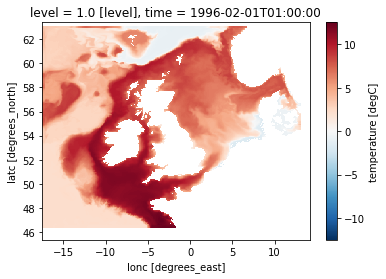

In [25]:
GETM['temp'].isel(time=0, level=0).plot()

It will automatically plot 2D shading or 1D lines, dependent on the shape of the DataArray. 

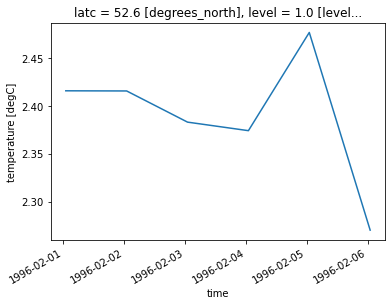

In [26]:
GETM.temp.sel(lonc=1.75, latc=52.6, level=1, method='nearest').plot()

## Other plotting packages are still available

You may still want to tailor plots to your own design e.g. creating figures for publication or presentation. 

For example, let's look an example with cartopy.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

Define a general mapping function

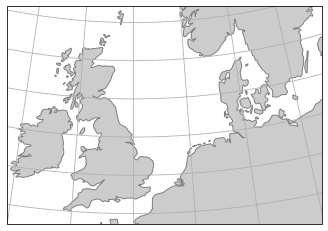

In [28]:
#def make_map(ds, var='', title=None, units=None):
def make_map():
    # create figure and axes instances
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, projection=ccrs.Stereographic(central_latitude=60))
    ax.set_extent([-10, 15, 49, 60], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(draw_labels=False)
    
    feature = cartopy.feature.NaturalEarthFeature(name='coastline',
                                                  category='physical',
                                                  scale='50m',
                                                  edgecolor='0.5',
                                                  facecolor='0.8')
    ax.add_feature(feature)
    return fig, ax

make_map();

We can plot our chosen data on the map, and use attributes to create annotate the figure. 

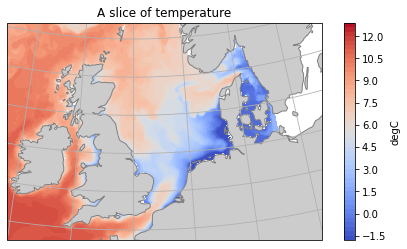

In [29]:
# Extract our chosen data and coordinates
latc = GETM.coords['latc']
lonc = GETM.coords['lonc']

var = GETM['temp'].sel(time='1996-02-02T01:00:00', level=21)

# Create the figure (using function above)
fig, ax = make_map()

# draw filled contours onto the map axes (ax).
h = ax.contourf(lonc, latc, var, 50, cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# add colorbar.
cbar = fig.colorbar(h)
# with unit label
cbar.set_label(var.units)

# add a title
ax.set_title(f'A slice of {var.long_name}');

---

#### Reminder: Choice of colormaps

The "default" colormap in python is viridis. However, colormaps can (and should) be varied to suit the data being shown.  
For example, you would likely prefer a *sequential* scale for bathymetry, as opposed to a *diverging* scale for rainfall anomalies? 

There is a large variety of maps to choose from in matplotlib, as shown [here](https://matplotlib.org/2.0.1/users/colormaps.html). 

**You should always choose *perceptually uniform* shading to ensure that data is not misrepresented.**

There are a large number of articles to explaing why you should avoid using rainbow/jet e.g.    
* [The end of the rainbow](http://www.climate-lab-book.ac.uk/2014/end-of-the-rainbow/)
* [A dangerous rainbow: Why colormaps matter](https://blogs.mathworks.com/headlines/2018/10/10/a-dangerous-rainbow-why-colormaps-matter/)


---

## Arithmetic operations

You can work with DataArrays in the same way as a NumPy array.  

Benefit here is that calculations using DataArrays will give a result that is also a DataArray. 

<class 'xarray.core.dataarray.DataArray'>


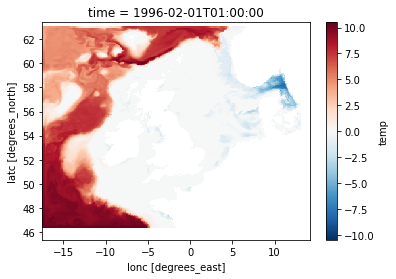

In [30]:
top = GETM['temp'].isel(time=0, level=4)
bottom = GETM['temp'].isel(time=0, level=0)

diff = top - bottom

print(type(diff))
diff.plot()

### Available methods and statistics

Methods available in pandas, are also available in xarray.  

When performing calculations, can refer to dimensions by name or axis number. 

(5, 360, 396)


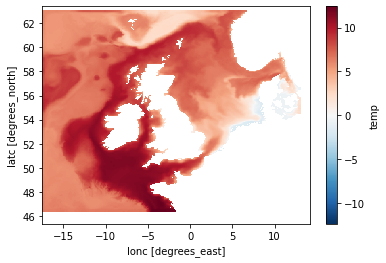

In [31]:
# average over time (using axis number)
time_ave = GETM['temp'].mean(axis=0) 
print(time_ave.shape)

# average over time and level (vertical)
timelev_ave = GETM['temp'].mean(['time','level'])
timelev_ave.plot()

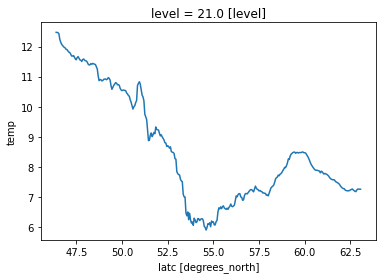

In [32]:
# average over time and longitude 
# i.e. zonal average (meridional section)
timelon_ave = GETM['temp'].mean(['time','lonc']).isel(level=4)
timelon_ave.plot()

---

## Dataset can easily be saved to a new netCDF file

Let's create a new dataset, containing just the average temperature, over time and level. 

In [33]:
# Create a subset of the dataset, average over axes: 
ds_temp = GETM[['temp']].mean('time','level')

In [34]:
# output to netcdf
ds_temp.to_netcdf('../data/temp_avg_level_time.nc')

Note the extra brackets used to extract the temperature variable: 

In [35]:
# When variable names are passed in a list, this produces a new Dataset:
print(type( GETM[['temp']]) )

# Passing just a string extracts the variable into a DataArray
print(type( GETM['temp'])   )

<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataarray.DataArray'>


---

# Exercise 2


From our GETM dataset again, we want to investigate the variability of temperature with depth across the seabed.  

a) Extract bathymetry from the dataset. 

b) Extract temperature at the seabed (level index = 0), and average over time. 

c) Produce a scatter plot of depth (bathymetry) vs. seabed temperature. 

In [36]:
# Your code here: 
# a)


In [37]:
# b)


In [38]:
# c)


---

# Bonus Exercise

For those who have finished the exercises above, and want more... 

Earlier we mentioned that you can also access remote data sets online. e.g.

In [39]:
remote_data = xr.open_dataset(
      'https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/2020/176/A2020176.L3m_DAY_CHL_chlor_a_9km.nc')

From this remote dataset: 
    
a) Extract the chlorophyll concentration, covering just the North Sea (or another region of your choice).

b) Plot a map to show your result - check you've made a subset of the right region!

In [40]:
# Your code here: 
# a) 
# Hint: You will need to extract the relevant variable over a range of latitude and londitude values.
#  * Find the relevant variable name to extract from the data set. 
#  * Extract coordinate values if needed?
#  * Subset over your chose range of latitude and longitude. 


In [41]:
# b) 
# Note: data is only downloaded when you make the plot


---
---
---


# More on the netCDF file format

## History

* netCDF is a collection of formats for storing arrays
* popular scientific file format for gridded datasets

    * netCDF classic
        * more widespread
        * 2 GB file limit (if you don't use the unlimited dimension)
        * often preffered for distributing products

    * netCDF 64 bit offset
        * supports larger files

    * NetCDF4
        * based on HDF5
        * compression
        * multiple unlimited variables
        * new types inc. user defined
        * herarchical groups
                

* Developed by Unidata-UCAR with the aim of storing climate model data (3D+time)
* Auxilary information about each variable can be added
* Readable text equivalent called CDL (use ncdump/ncgen)
* Can be used with Climate and Forecast (CF) data convention
http://cfconventions.org/

## Data model

* Dimensions:describe the axes of the data arrays.
* Variables: N-dimensional arrays of data.
* Attributes: annotate variables or files with small notes or supplementary metadata.

Example for an ocean model dataset:

* Dimensions
    * lat
    * lon
    * depth
    * time
* Variable
    * Temperature
    * Salinity
    
    
* Global Attibutes
    * Geographic grid type
    * History

* Variable attributes (Temperature)
    * Long_name: "sea water temperature" 
    * Missing_value: 1.09009E36
    * Units: deg. C
    * range: -2:50

## Tools for working with netCDF files


### Readable by many software tools

NetCDF can be read by many different software tools e.g. ArcGIS, QGIS, Surfer, Ferret, Paraview etc.

It can also be read by many different languages (one of the key motivations behind its use). 

### C and Fortran libraries

These are used to underpin interfaces to other languages such as python (e.g. python package netCDF4)

Include in these are ncdump/ncgen software, used to convert to and from human-readable format.


### nco tools 

An *extremely useful* set of tools, to process netCDF files directly from the command line. 

For example, files can be subset, concatenated, averaged, or variables processed with simple arithmetic. 

Full documentation, showing the wide range of functionality, can be found here: http://nco.sourceforge.net/nco.html.


### cdo tools
Another powerful command line tool: https://code.mpimet.mpg.de/projects/cdo/

## Quick viewers?

To view the file contents quickly and easily (without reading into python or elsewhere), there are a few different options.

e.g. ncdump, ncview, panoply, pyncview, etc.

### ncdump

This program should be available through your python installation, and is a useful way to quickly check the contents or attributes of a netCDF file.  

You can peek inside your netcdf file from the prompt window (or terminal) using `ncdump -h <filename>` 

Be sure to use the `-h` option, otherwise it will literally dump the entire contents of your file into the screen in front of you (not what you normally want!).

e.g.: 

```
$ ncdump -h data/cefas_GETM_nwes.nc4
netcdf cefas_GETM_nwes {
dimensions:
        latc = 360 ;
        lonc = 396 ;
        time = UNLIMITED ; // (6 currently)
        level = 5 ;
variables:
        double bathymetry(latc, lonc) ;
                bathymetry:units = "m" ;
                bathymetry:long_name = "bathymetry" ;
                bathymetry:valid_range = -5., 4000. ;
                bathymetry:_FillValue = -10. ;
                bathymetry:missing_value = -10. ;
        float h(time, level, latc, lonc) ;
                h:units = "m" ;
                h:long_name = "layer thickness" ;
                h:_FillValue = -9999.f ;
                h:missing_value = -9999.f ;
        double latc(latc) ;
                latc:units = "degrees_north" ;
        double level(level) ;
                level:units = "level" ;
        double lonc(lonc) ;
                lonc:units = "degrees_east" ;
        float temp(time, level, latc, lonc) ;
                temp:units = "degC" ;
                temp:long_name = "temperature" ;
                temp:valid_range = -2.f, 40.f ;
                temp:_FillValue = -9999.f ;
                temp:missing_value = -9999.f ;
        double time(time) ;
                time:long_name = "time" ;
                time:units = "seconds since 1996-01-01 00:00:00" ;
...
                
```

# References

* xarray [docs](http://xarray.pydata.org/en/stable/) 
* netCDF4 [docs](https://unidata.github.io/netcdf4-python/netCDF4/index.html)
* Stephan Hoyer's [ECMWF talk](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/edit#slide=id.g2b68f9254d_1_27)